In [1]:
#import needed libraries
import pandas as pd
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline 


We will be using a dataset from National Transportation Safety Board that contains aviation data from 1962 to 2023. 


In [2]:
#import the data
aviation_data = pd.read_csv('/Users/raquelpalumbo/Documents/Flatiron/dsc-data-science-env-config/AviationData.csv', encoding = 'latin-1', low_memory=False)

In [3]:
#view the dataset
aviation_data.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,10/24/48,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,7/19/62,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,8/30/74,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,6/19/77,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12/9/00
4,20041105X01764,Accident,CHI79FA064,8/2/79,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [4]:
#get information on the dataset
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

We do not need the following columns as they will not be relevant to the analysis. 

In [5]:
####clean the data###

In [6]:
#remove columns that contain data we will not need
aviation_data = aviation_data.drop(['Airport.Code','Air.carrier','Investigation.Type','Latitude', 'Longitude','Accident.Number', 'Publication.Date', 'Event.Id','Registration.Number', 'FAR.Description', 'Report.Status', 'Amateur.Built', 'Number.of.Engines'], axis =1)

In [7]:
#elimate data on aircraft other than airplanes, since the company will only be purchasing airplanes
aviation_data.drop(aviation_data.loc[aviation_data['Aircraft.Category']!='Airplane'].index, inplace=True)
aviation_data = aviation_data.drop('Aircraft.Category', axis =1)

In [8]:
#clean up the data on injuries

#remove all missing data from the injuries columns
aviation_data.loc[:, ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']] = aviation_data[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].fillna(0)
aviation_data.drop(aviation_data.loc[aviation_data['Total.Fatal.Injuries']=='Boeing'].index, inplace=True)
aviation_data.drop(aviation_data.loc[aviation_data['Total.Fatal.Injuries']=='nan'].index, inplace=True)

#convert all injury counts to integers to use in mathematical operations
aviation_data[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']] = aviation_data[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].astype(int)

#add a column for the total number of injured passsengers
aviation_data['Total.Injuries']=(aviation_data['Total.Fatal.Injuries']+aviation_data['Total.Minor.Injuries']+aviation_data['Total.Serious.Injuries']).astype(int)

#add a column for the total number of passengers
aviation_data['Num.Passengers']= aviation_data['Total.Injuries']+aviation_data['Total.Uninjured']

#drop any colums with no passengers
aviation_data.drop(aviation_data.loc[aviation_data['Num.Passengers']==0].index, inplace=True)

In [9]:
#clean up the make column 

#drop rows with no data on make
aviation_data.dropna(subset = ['Make'], inplace = True)

#clean up the formatting of values
aviation_data['Make']=aviation_data['Make'].map(lambda x: x.title())

#reassign Mcdonnell Douglas to Boeing
aviation_data['Make'].replace('Mcdonnell Douglas', 'Boeing', inplace=True)
aviation_data['Make'].replace('Airbus Industrie', 'Airbus', inplace=True)

The first thing we will look at will be which aircraft the company should purchase. We will first look at the make and then the model.

For this, we will use the amount of uninjured passengers to measure the safest aircrafts for the company to use.

In [10]:
#find the total of each passenger outcome for each make then get the 5 planes with the most passengers/data points
safest_makes = aviation_data[['Make', 'Model', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Num.Passengers']].groupby(['Make']).sum().nlargest(5, columns='Num.Passengers')

In [11]:
#add a column for the percentage of uninjured passengers
safest_makes['Percentage.Uninjured'] = ((safest_makes['Total.Uninjured']/safest_makes['Num.Passengers'])*100)

In [12]:
#find the make with the highest percentage of uninjured passengers
safest_makes.nlargest(5, columns='Percentage.Uninjured')

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Num.Passengers,Percentage.Uninjured
Make,,,,,,
Boeing,3309,1353,1242,99682,105586,94.408350
Airbus,1668,210,107,24551,26536,92.519596
Embraer,319,123,59,4801,5302,90.550736
Cessna,3059,1824,1500,10735,17118,62.711765
Piper,1899,960,827,5522,9208,59.969592


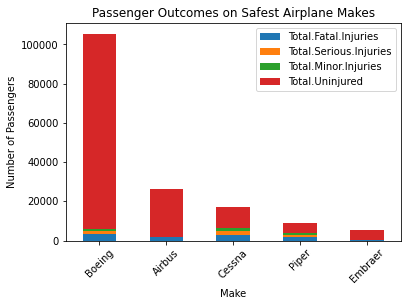

<Figure size 1440x864 with 0 Axes>

In [13]:
safest_makes.drop(['Num.Passengers', 'Percentage.Uninjured'], axis =1).plot(kind='bar', stacked= True ,title = 'Passenger Outcomes on Safest Airplane Makes', ylabel='Number of Passengers', rot = 45)
plt.figure(figsize=(20, 12))
plt.tight_layout()
plt.savefig('Passenger Outcomes on Safest Makes.png')
plt.show()

In [14]:
#convert all columns to percentages
safest_makes['Total.Fatal.Injuries'] = ((safest_makes['Total.Fatal.Injuries']/safest_makes['Num.Passengers'])*100)
safest_makes['Total.Serious.Injuries'] = ((safest_makes['Total.Serious.Injuries']/safest_makes['Num.Passengers'])*100)
safest_makes['Total.Minor.Injuries'] = ((safest_makes['Total.Serious.Injuries']/safest_makes['Num.Passengers'])*100)

In [15]:
#rename the columns
safest_makes.rename(columns={'Total.Fatal.Injuries':'Percentage.Fatal.Injuries', 'Total.Serious.Injuries':'Percentage.Serious.Injuries', 'Total.Minor.Injuries':'Percentage.Minor.Injuries'},inplace=True)

safest_makes= safest_makes.drop(['Total.Uninjured', 'Num.Passengers'], axis=1).sort_values('Percentage.Uninjured', ascending=False)
safest_makes.round(2)

,Percentage.Fatal.Injuries,Percentage.Serious.Injuries,Percentage.Minor.Injuries,Percentage.Uninjured
Make,,,,
Boeing,3.13,1.28,0.00,94.41
Airbus,6.29,0.79,0.00,92.52
Embraer,6.02,2.32,0.04,90.55
Cessna,17.87,10.66,0.06,62.71
Piper,20.62,10.43,0.11,59.97


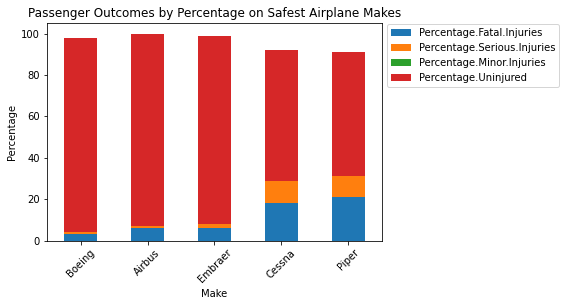

<Figure size 720x432 with 0 Axes>

In [16]:
#plot the passenger outcomes by percentages
safest_makes.round().plot(kind='bar', stacked=True, title= 'Passenger Outcomes by Percentage on Safest Airplane Makes', ylabel='Percentage', rot=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))
plt.figure(figsize=(10, 6))
plt.savefig('Passenger Outcomes By Percentage - Safest Makes')
plt.show()

In [17]:
#find the safest models

In [18]:
#find the total of each passenger outcome for each make then get the 5 planes with the most passengers/data points
safest_models = aviation_data[['Make', 'Model', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Num.Passengers']].groupby(['Make', 'Model']).sum().nlargest(5, columns='Num.Passengers')
safest_models

Total.Fatal.Injuries  Total.Serious.Injuries  \
Make   Model                                                 
Boeing 737                    1341                     339   
       777                       0                       6   
       767                     128                     110   
Airbus A320                    283                      11   
       A330                    331                      19   

              Total.Minor.Injuries  Total.Uninjured  Num.Passengers  
Make   Model                                                         
Boeing 737                      83            20529           22292  
       777                      22             8525            8553  
       767                      21             5521            5780  
Airbus A320                     13             3358            3665  
       A330                     24             2991            3365

In [19]:
#add a column for the percentage of uninjured passengers
safest_models['Percentage.Uninjured'] = ((safest_models['Total.Uninjured']/safest_models['Num.Passengers'])*100)

In [20]:
#find the make with the highest percentage of uninjured passengers
safest_models.nlargest(5, columns='Percentage.Uninjured')

Total.Fatal.Injuries  Total.Serious.Injuries  \
Make   Model                                                 
Boeing 777                       0                       6   
       767                     128                     110   
       737                    1341                     339   
Airbus A320                    283                      11   
       A330                    331                      19   

              Total.Minor.Injuries  Total.Uninjured  Num.Passengers  \
Make   Model                                                          
Boeing 777                      22             8525            8553   
       767                      21             5521            5780   
       737                      83            20529           22292   
Airbus A320                     13             3358            3665   
       A330                     24             2991            3365   

              Percentage.Uninjured  
Make   Model                        
Boeing 777               99.672629  
       767               95.519031  
       737               92.091333  
Airbus A320              91.623465  
       A330              88.885587

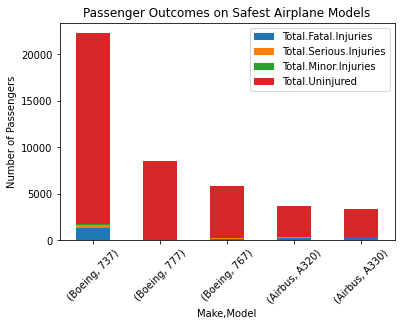

In [21]:
safest_models.drop(['Num.Passengers', 'Percentage.Uninjured'], axis =1).plot(kind='bar', stacked= True ,title = 'Passenger Outcomes on Safest Airplane Models', ylabel='Number of Passengers', rot=45);

In [22]:
#convert all columns to percentages
safest_models['Total.Fatal.Injuries'] = ((safest_models['Total.Fatal.Injuries']/safest_models['Num.Passengers'])*100)
safest_models['Total.Serious.Injuries'] = ((safest_models['Total.Serious.Injuries']/safest_models['Num.Passengers'])*100)
safest_models['Total.Minor.Injuries'] = ((safest_models['Total.Serious.Injuries']/safest_models['Num.Passengers'])*100)

In [23]:
#rename the columns
safest_models.rename(columns={'Total.Fatal.Injuries':'Percentage.Fatal.Injuries', 'Total.Serious.Injuries':'Percentage.Serious.Injuries', 'Total.Minor.Injuries':'Percentage.Minor.Injuries'},inplace=True)

safest_models= safest_models.drop(['Total.Uninjured', 'Num.Passengers'], axis=1).sort_values('Percentage.Uninjured', ascending=False)
safest_models.round(2)

Percentage.Fatal.Injuries  Percentage.Serious.Injuries  \
Make   Model                                                           
Boeing 777                         0.00                         0.07   
       767                         2.21                         1.90   
       737                         6.02                         1.52   
Airbus A320                        7.72                         0.30   
       A330                        9.84                         0.56   

              Percentage.Minor.Injuries  Percentage.Uninjured  
Make   Model                                                   
Boeing 777                         0.00                 99.67  
       767                         0.03                 95.52  
       737                         0.01                 92.09  
Airbus A320                        0.01                 91.62  
       A330                        0.02                 88.89

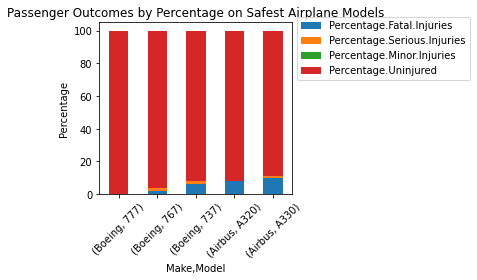

In [24]:
#plot the passenger outcomes by percentages
safest_models.round().plot(kind='bar', stacked=True, title= 'Passenger Outcomes by Percentage on Safest Airplane Models', ylabel='Percentage', rot =45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))
plt.figsize=(20,80)
plt.tight_layout()

plt.savefig('Passenger Outcomes By Percentage - Safest Models.jpg')
plt.show()

Next we will look at which regions are the safest to fly in. Let's see where we have the most data.

In [25]:
#check which country we have the most data on
aviation_data['Country'].value_counts()

United States               24114
Brazil                        225
Mexico                        160
Canada                        160
United Kingdom                141
                            ...  
Turks and Caicos Islands        1
Mauritania                      1
Ghana                           1
Paraguay                        1
Lebanon                         1
Name: Country, Length: 153, dtype: int64

So we will start with the United States. This would naturally be the first location as a (presumed) US based company, but we also have the most data on.

We will focus on which region has the most unjured passengers. 

In [26]:
####see which regions are the safest to fly in

In [27]:
regional_aviation_data = aviation_data

#add a column for the states
aviation_data['State']= aviation_data['Location'].str[-2:]

In [28]:
#define US regions using the regions defined by national geographic on https://education.nationalgeographic.org/resource/united-states-regions/
west =['WA', 'OR', 'CA', 'NV', 'UT', 'ID', 'MT', 'WY', 'CO', 'AK', 'HI']
southwest = ['AZ', 'NM', 'OK', 'TX']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'WI', 'IL', 'IN', 'MI', 'OH']
southeast = ['AR', 'LA', 'MS', 'AL', 'TN','KY', 'WV', 'MD', 'DC', 'VA', 'NC', 'SC', 'GA', 'FL', 'DE']
northeast = ['PA', 'NY', 'NJ', 'RI', 'MA', 'NH', 'VT', 'ME', 'CT']

#check that all 50 states were accounted for
assert len(west)+len(southwest)+len(northeast)+len(southeast)+len(midwest) == 50

In [29]:
#assign a region to each state
for index, row in regional_aviation_data.iterrows():
    if row['State'] in west:
        regional_aviation_data.loc[index, 'Region'] = 'West'
    elif row['State'] in southwest:
        regional_aviation_data.loc[index, 'Region'] = 'Southwest'
    elif row['State'] in midwest:
        regional_aviation_data.loc[index, 'Region'] = 'Midwest'
    elif row['State'] in southeast:
        regional_aviation_data.loc[index, 'Region'] = 'Southeast'
    elif row['State'] in northeast:
        regional_aviation_data.loc[index, 'Region'] = 'Northeast'

In [30]:
regional_aviation_data = regional_aviation_data.groupby('Region').sum()
regional_aviation_data

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Total.Injuries,Num.Passengers
Region,,,,,,
Midwest,1009,882,782,16686,2673,19359
Northeast,646,625,502,15222,1773,16995
Southeast,1829,1468,1143,26082,4440,30522
Southwest,1072,767,722,9726,2561,12287
West,2295,2051,1536,28514,5882,34396


In [31]:
injury_data = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']

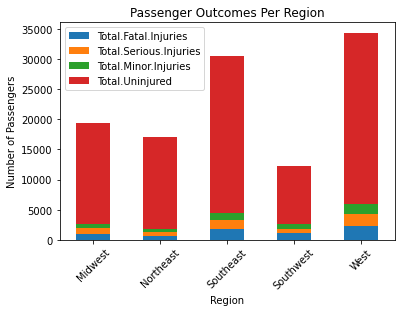

In [32]:
regional_aviation_data.groupby(['Region'])[injury_data].sum().plot(kind='bar', stacked = True, title='Passenger Outcomes Per Region', ylabel= 'Number of Passengers', rot=45)
plt.savefig('Regional Passenger Outcomes')
plt.show()

In [33]:
#convert all columns to percentages
regional_aviation_data['Total.Fatal.Injuries'] = ((regional_aviation_data['Total.Fatal.Injuries']/regional_aviation_data['Num.Passengers'])*100)
regional_aviation_data['Total.Serious.Injuries'] = ((regional_aviation_data['Total.Serious.Injuries']/regional_aviation_data['Num.Passengers'])*100)
regional_aviation_data['Total.Minor.Injuries'] = ((regional_aviation_data['Total.Serious.Injuries']/regional_aviation_data['Num.Passengers'])*100)
regional_aviation_data['Total.Uninjured'] = ((regional_aviation_data['Total.Uninjured']/regional_aviation_data['Num.Passengers'])*100)

#rename the columns
regional_aviation_data.rename(columns={'Total.Fatal.Injuries':'Percentage.Fatal.Injuries', 'Total.Serious.Injuries':'Percentage.Serious.Injuries', 'Total.Minor.Injuries':'Percentage.Minor.Injuries', 'Total.Uninjured':'Percentage.Uninjured'},inplace=True)

In [34]:
#drop number of passengers column
regional_aviation_data= regional_aviation_data.drop(['Num.Passengers'], axis=1).sort_values('Percentage.Uninjured', ascending=False)

In [35]:
regional_aviation_data.round(2)

,Percentage.Fatal.Injuries,Percentage.Serious.Injuries,Percentage.Minor.Injuries,Percentage.Uninjured,Total.Injuries
Region,,,,,
Northeast,3.80,3.68,0.02,89.57,1773
Midwest,5.21,4.56,0.02,86.19,2673
Southeast,5.99,4.81,0.02,85.45,4440
West,6.67,5.96,0.02,82.90,5882
Southwest,8.72,6.24,0.05,79.16,2561


In [36]:
#plot the regional passenger outcomes by percentage
regional_aviation_data.drop('Total.Injuries', axis=1, inplace=True)

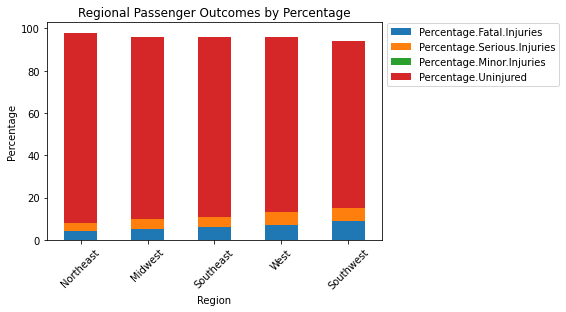

<Figure size 2880x1728 with 0 Axes>

In [37]:
#plot the passenger outcomes by percentages
regional_aviation_data.round().plot(kind='bar', stacked=True, title= 'Regional Passenger Outcomes by Percentage', ylabel='Percentage', rot = 45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))
plt.figure(figsize=(40, 24))
plt.savefig('Regional Passenger Outcomes By Percentage')
plt.show()

We should also take a look at what types of flights we should avoid. We will see what flight puropses have the highest fatalities

In [38]:
###find the aircraft usage that is the most risky

In [39]:
aviation_data_by_purpose = aviation_data.groupby('Purpose.of.flight').sum()

In [40]:
#drop the unknown purpose
aviation_data_by_purpose.drop(index='Unknown', inplace=True)


In [41]:
#convert all columns to percentages
aviation_data_by_purpose['Total.Fatal.Injuries'] = ((aviation_data_by_purpose['Total.Fatal.Injuries']/aviation_data_by_purpose['Num.Passengers'])*100)
aviation_data_by_purpose['Total.Serious.Injuries'] = ((aviation_data_by_purpose['Total.Serious.Injuries']/aviation_data_by_purpose['Num.Passengers'])*100)
aviation_data_by_purpose['Total.Minor.Injuries'] = ((aviation_data_by_purpose['Total.Minor.Injuries']/aviation_data_by_purpose['Num.Passengers'])*100)
aviation_data_by_purpose['Total.Uninjured'] = ((aviation_data_by_purpose['Total.Uninjured']/aviation_data_by_purpose['Num.Passengers'])*100)

In [42]:
#drop unneeded columns
aviation_data_by_purpose.drop(['Total.Injuries', 'Num.Passengers'], axis = 1, inplace = True)

In [43]:
unsafest_flight_purposes = aviation_data_by_purpose.sort_values('Total.Fatal.Injuries', ascending=False).nlargest(5, columns='Total.Fatal.Injuries')
unsafest_flight_purposes.round()

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
Purpose.of.flight,,,,
ASHO,88.0,6.0,0.0,6.0
Ferry,49.0,5.0,6.0,40.0
Firefighting,46.0,0.0,11.0,43.0
Air Race show,35.0,10.0,9.0,46.0
Aerial Observation,32.0,18.0,10.0,41.0


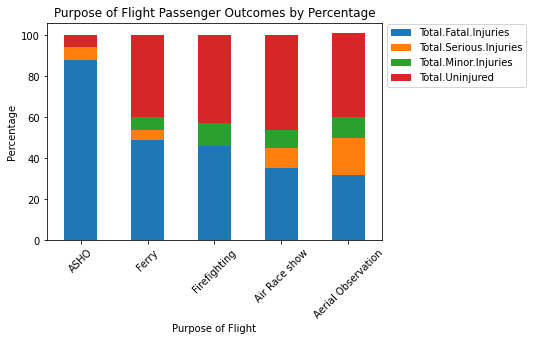

<Figure size 720x432 with 0 Axes>

In [44]:
#plot the passenger outcomes by percentages
unsafest_flight_purposes.round().plot(kind='bar', stacked=True, title= 'Purpose of Flight Passenger Outcomes by Percentage', ylabel='Percentage', xlabel='Purpose of Flight', rot = 45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))
plt.figure(figsize=(10, 6))
plt.savefig('Purpose of Flight Passenger Outcomes')

In [45]:
###will implement if one of the others doesnt count

In [46]:
###figure out which of the safest makes we picked sustains the least damage

In [47]:
#top_three_safest_makes=safest_makes.nlargest(3, columns = 'Percentage.Uninjured')

In [48]:
#top_three_safest_makes = aviation_data[aviation_data['Make'].isin(top_three_safest_makes.index)]

In [49]:
#top_three_safest_makes.dropna(subset=['Aircraft.damage'], inplace=True)

In [50]:
#top_three_safest_makes['Aircraft.damage'].replace('Unknown', 'Destroyed',inplace=True)

In [51]:
#top_three_safest_makes.groupby('Make')

In [52]:
#top_three_safest_makes

In [53]:
#five_safest_makes = five_safest_makes.groupby('Make')['Aircraft.damage'].value_counts()

In [54]:
#five_safest_makes.unstack().plot(kind='bar', stacked='True', ylabel = "Number of Incidents", title='Aircraft Damage by Make');